In [16]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [17]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pandas as pd
import csv

In [18]:
import os
os.chdir('/home/st122283/labs/Forex-Prediction')
print(os.getcwd())
data = pd.read_csv("dataset/dataset_eurousd.csv",sep=None)

/home/st122283/labs/Forex-Prediction


In [19]:
data.rename(columns={'<DATE>': 'DATE', '<TIME>': 'TIME','<OPEN>':'OPEN', '<HIGH>':'HIGH', '<LOW>':'LOW', '<CLOSE>':'CLOSE', '<TICKVOL>':'TICKVOL', '<VOL>':'VOL', '<SPREAD>':'SPREAD'}, inplace=True)

In [20]:
data

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
0,2012.04.09,00:00:00,1.30961,1.30965,1.30662,1.30687,2151,0,13
1,2012.04.09,01:00:00,1.30688,1.30861,1.30668,1.30847,1490,0,12
2,2012.04.09,02:00:00,1.30848,1.30876,1.30441,1.30443,2226,0,12
3,2012.04.09,03:00:00,1.30444,1.30524,1.30330,1.30508,2322,0,13
4,2012.04.09,04:00:00,1.30509,1.30618,1.30504,1.30581,1379,0,12
...,...,...,...,...,...,...,...,...,...
61997,2022.04.08,14:00:00,1.08861,1.08881,1.08592,1.08638,3897,0,0
61998,2022.04.08,15:00:00,1.08637,1.08660,1.08504,1.08531,4443,0,0
61999,2022.04.08,16:00:00,1.08531,1.08581,1.08364,1.08399,6250,0,0
62000,2022.04.08,17:00:00,1.08399,1.08804,1.08388,1.08727,6825,0,0


In [21]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
# add time index
# data['time_idx'] = 0
index_value = 0;
counter = 0;


for index, row in data.iterrows():
    data.loc[index,'time_idx'] = index_value;
    counter = counter + 1;
    if(counter > 5):
        index_value = index_value + 1;
        counter = 0;

In [22]:
data['time_idx']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
61997    10332.0
61998    10333.0
61999    10333.0
62000    10333.0
62001    10333.0
Name: time_idx, Length: 62002, dtype: float64

In [23]:
len(data.loc[data['time_idx'] == 10333])

4

In [24]:
data.describe()

,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD,time_idx
count,62002.000000,62002.000000,62002.000000,62002.000000,62002.000000,6.200200e+04,62002.000000,62002.000000
mean,1.185940,1.186719,1.185184,1.185940,3358.609513,1.354876e+09,4.064385,5166.333344
std,0.090433,0.090415,0.090448,0.090431,2721.869574,3.574439e+09,3.800078,2983.096677
min,1.035550,1.037000,1.032490,1.035560,1.000000,0.000000e+00,0.000000,0.000000
25%,1.116670,1.117430,1.116000,1.116670,1404.000000,0.000000e+00,1.000000,2583.000000
50%,1.162500,1.163250,1.161770,1.162500,2571.000000,0.000000e+00,3.000000,5166.000000
75%,1.244650,1.245675,1.243805,1.244668,4444.000000,0.000000e+00,7.000000,7750.000000
max,1.396280,1.399320,1.394860,1.396290,37898.000000,3.295386e+10,122.000000,10333.000000


In [25]:
data['time_idx'] = data['time_idx'].astype(int)


In [26]:
data['Currency'] = "EURUSD"

In [27]:
data = data.drop(data.tail(61402).index)

In [28]:
data['time_idx']

0       0
1       0
2       0
3       0
4       0
       ..
595    99
596    99
597    99
598    99
599    99
Name: time_idx, Length: 600, dtype: int64

In [29]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="CLOSE",
    group_ids=["Currency"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={}, 
    time_varying_known_reals=["time_idx", "HIGH", "LOW", "OPEN", "TICKVOL"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(
        groups=["Currency"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

In [30]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.0006983081693761051

In [31]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    devices=2,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.3k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Finding best initial lr: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


suggested learning rate: 2.754228703338168


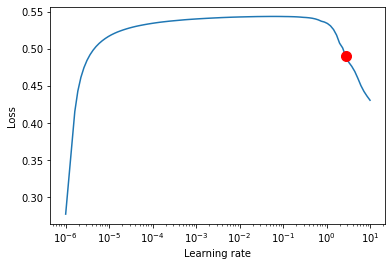

In [32]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [33]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    devices=2,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.3k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:111: operator(): block: [0,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

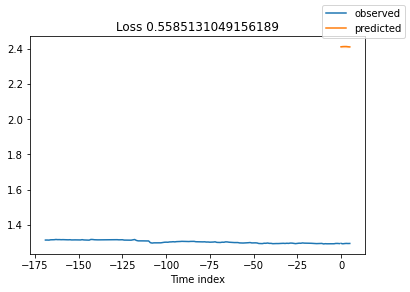

In [34]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);